# SENTIMENT ANALYSIS
Sentiment analysis also known as 'opinion mining' is the ability to classify opinions expressed in text and determine whether authors attitude is positive,neutral or negative.
This classification is vital as it helps make brand decisions and build brand reputations over time. It also helps monitor customer feedback,brand and brand campaign.
In this case we will use facebook comments attributed to Ponea Health account and products offered by Ponea Health.
We will attempt to use both the three and five point ordinal scales to classify the comments.
Since sentiment analysis involves natural language processing we will download and import a couple of python libraries that we intend to use.
We will use a neural network in our attempt to build a model that classifies sentiments.

In [1]:
#importing requisite libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
stop_words=set(stopwords.words('english'))

In [2]:
#installing facebook-scraper(extracts posts withouth using the API Key)
#pip install facebook_scraper==0.2.49

In [3]:
#enabling GPU accelerator if available
#DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print (f'Device Available: DEVICE')

### Data Mining and Obtaining Facebook Comments From Ponea Kenya

In [4]:
#getting comments from facebook using facebook_scraper 
#scrapes posts and comments withou the API Key
#'Comments=True/any number limits the comments'
#pages are the number of pages the script runs to obtain posts and comments
from facebook_scraper import *

#obtaining data from facebook using the facebook_scraper
listposts=[]
for posts in get_posts('PoneaHealth', pages=1000,options={'comments':True}):
    listposts.append(posts)
print('Number of Posts:{}'.format(len(listposts)))

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Number of Posts:166


In [5]:
#copying raw data into a dataframe
columns=['post_id','time', 'text', 'likes', 'comments', 'shares', 'comments_full']
df_posts=pd.DataFrame(listposts)[columns]

In [6]:
df_posts

,post_id,time,text,likes,comments,shares,comments_full
0,525943392459447,2022-02-04 12:32:47,"As we mark World Cancer Day, let's be intentio...",1,0,0,[]
1,504735794580207,2022-01-01 16:28:34,Happy New Year from all of us at Ponea Health....,4,0,0,[]
2,500781688308951,2021-12-26 14:15:09,"Happy Boxing Day, from Ponea Health.\n\n#Ponea...",0,0,0,[]
3,499993968387723,2021-12-25 11:55:27,"Ponea Health wishes you a happy, healthy, and ...",0,0,0,[]
4,497610005292786,2021-12-21 22:03:37,Join us tomorrow evening as we debunk the Omic...,3,0,0,[]
...,...,...,...,...,...,...,...
161,134143058306151,2020-06-12 12:28:12,We are now hiring! Dreaming of creating a star...,6,1,2,"[{'comment_id': '141896854197438', 'comment_ur..."
162,106687097718414,2020-05-15 14:36:36,UNLEARNING WHAT YOU THOUGHT YOU KNEW ABOUT COS...,2,0,0,[]
163,106680087719115,2020-05-15 14:28:20,,4,0,0,[]
164,106678241052633,2020-05-15 14:20:52,,4,0,0,[]


In [7]:
df_posts.shape

(166, 7)

In [8]:
df_posts.head()

,post_id,time,text,likes,comments,shares,comments_full
0,525943392459447,2022-02-04 12:32:47,"As we mark World Cancer Day, let's be intentio...",1,0,0,[]
1,504735794580207,2022-01-01 16:28:34,Happy New Year from all of us at Ponea Health....,4,0,0,[]
2,500781688308951,2021-12-26 14:15:09,"Happy Boxing Day, from Ponea Health.\n\n#Ponea...",0,0,0,[]
3,499993968387723,2021-12-25 11:55:27,"Ponea Health wishes you a happy, healthy, and ...",0,0,0,[]
4,497610005292786,2021-12-21 22:03:37,Join us tomorrow evening as we debunk the Omic...,3,0,0,[]


In [9]:
df_posts.tail()

,post_id,time,text,likes,comments,shares,comments_full
161,134143058306151,2020-06-12 12:28:12,We are now hiring! Dreaming of creating a star...,6,1,2,"[{'comment_id': '141896854197438', 'comment_ur..."
162,106687097718414,2020-05-15 14:36:36,UNLEARNING WHAT YOU THOUGHT YOU KNEW ABOUT COS...,2,0,0,[]
163,106680087719115,2020-05-15 14:28:20,,4,0,0,[]
164,106678241052633,2020-05-15 14:20:52,,4,0,0,[]
165,106678644385926,2020-05-15 14:20:52,,4,0,0,[]


In [10]:
#saving the dataframe as a .csv file
df_posts.to_csv('facebook_sentiment_test.csv')

# Building the Model to Use
In this instance we will build a neural network that we will then use to predict sentiments from the facebook comments. Due to the limited comments extracted from the ponea kenya facebook page, we used dummy data to build the model which will then be used to predict the polarity the facebook comments obtained from ponea kenya facebook page.

In [11]:
#importing the  and data understanding
fb1=pd.read_csv('fb_sentiment_train.csv')
#the data picked out has comments and labels. The labels are O,P,N. They classify the sentiments in comments. The data also has rows and the sentiments of the comments are randomly distributed.

## Data Exploration and Cleaning

In [12]:
fb1.head()

,Unnamed: 0,FBPost,Label
0,0,Drug Runners and a U.S. Senator have somethin...,O
1,1,"Heres a single, to add, to Kindle. Just read t...",O
2,2,If you tire of Non-Fiction.. Check out http://...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle...,N


In [13]:
fb1.tail()

,Unnamed: 0,FBPost,Label
995,995,I liked it. Its youth oriented and I think th...,P
996,996,"I think the point of the commercial is that, e...",P
997,997,Kindle 3 is such a great product. I could not ...,P
998,998,develop a way to share books! that is a big d...,N
999,999,I love my kindle! =),P


In [14]:
fb1.shape

(1000, 3)

### Lowercasing Column names

In [15]:
fb1.columns=map(str.lower,fb1.columns)

In [16]:
fb1

,unnamed: 0,fbpost,label
0,0,Drug Runners and a U.S. Senator have somethin...,O
1,1,"Heres a single, to add, to Kindle. Just read t...",O
2,2,If you tire of Non-Fiction.. Check out http://...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle...,N
...,...,...,...
995,995,I liked it. Its youth oriented and I think th...,P
996,996,"I think the point of the commercial is that, e...",P
997,997,Kindle 3 is such a great product. I could not ...,P
998,998,develop a way to share books! that is a big d...,N


In [17]:
#checking for null values and replacing them
fb1.isnull().sum()

unnamed: 0    0
fbpost        0
label         0
dtype: int64

In [18]:
#checking for null,NaN,
#function to replace/remove null and NaN values and reconverting it df
#apply family
#explore visualization to describe data; tree maps,word cloud,network

### Lowercasing Comments and Removing Symbols Using RegEx

In [19]:
#we will lowercase the text in the comments and remove symbols using python library Regular Expressions
import re

In [20]:
fb1['fbpost']=fb1['fbpost'].apply(lambda x:x.lower())
fb1['fbpost']=fb1['fbpost'].apply((lambda x:re.sub('[^a-zA-z0-9\s]','',x)))

In [21]:
#data after cleaning
fb1

,unnamed: 0,fbpost,label
0,0,drug runners and a us senator have something ...,O
1,1,heres a single to add to kindle just read this...,O
2,2,if you tire of nonfiction check out httpwwwama...,O
3,3,ghost of round island is supposedly nonfiction,O
4,4,why is barnes and nobles version of the kindle...,N
...,...,...,...
995,995,i liked it its youth oriented and i think thi...,P
996,996,i think the point of the commercial is that ev...,P
997,997,kindle 3 is such a great product i could not b...,P
998,998,develop a way to share books that is a big dr...,N


### Tokenizing The Comments
Language in its original form cannot be accurately processed by a computer, so we need to breakdown the language to make it easier for the computer to understand. The first part of making sense of the comments data is by a process called tokenization which is splitting strings into smaller parts called tokens.
A token is a sequence of characters in text that serves as a unit. Based on how the tokens are created , they may consist of words, emoticons, hashtags, links, or even individual characters. A basic way of breaking language into tokens is by splitting the text based on whitespace and punctuation.
In this instance we will tokenize using whitespaces.

In [22]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(fb1['fbpost'].values)
X = tokenizer.texts_to_sequences(fb1['fbpost'].values)
X = pad_sequences(X)

##### Label Preparation

In [23]:
#checking labels
fb1.label.value_counts()

P    641
O    280
N     79
Name: label, dtype: int64

In [24]:
Y=pd.get_dummies(fb1['label']).values
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15,random_state=1)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_train.shape)

(850, 205) (850, 3)
(150, 205) (850, 3)


#### Building the Neural Network

In [25]:
#Preparing the Algorithm
#Sequential Model; Model type-LSTM model

In [29]:
embed_dim=200
lstm_out=200
model=Sequential()
model.add(Embedding(max_fatures,embed_dim,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out,dropout=0.2,recurrent_dropout=0.2)) #modifying output layers and fully conncected layers
model.add(Dense(3,activation='softmax')) #modify these.
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
#improve on depth of network since its a deep learning model.
#re-use my code on bayesian as done in class.
#transfer learning-
#leverage on pre-trained models in keras that i can import

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 205, 200)          400000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 205, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 721,403
Trainable params: 721,403
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Training The Model
batch_size=32
hist=model.fit(X_train,Y_train,epochs=7,batch_size=batch_size,verbose=2)

Epoch 1/7
27/27 - 29s - loss: 0.8902 - accuracy: 0.6176 - 29s/epoch - 1s/step
Epoch 2/7
27/27 - 28s - loss: 0.7659 - accuracy: 0.6482 - 28s/epoch - 1s/step
Epoch 3/7
27/27 - 29s - loss: 0.5841 - accuracy: 0.7682 - 29s/epoch - 1s/step
Epoch 4/7
27/27 - 27s - loss: 0.4476 - accuracy: 0.8388 - 27s/epoch - 1s/step
Epoch 5/7
27/27 - 28s - loss: 0.3645 - accuracy: 0.8800 - 28s/epoch - 1s/step
Epoch 6/7
27/27 - 27s - loss: 0.2588 - accuracy: 0.9282 - 27s/epoch - 987ms/step
Epoch 7/7


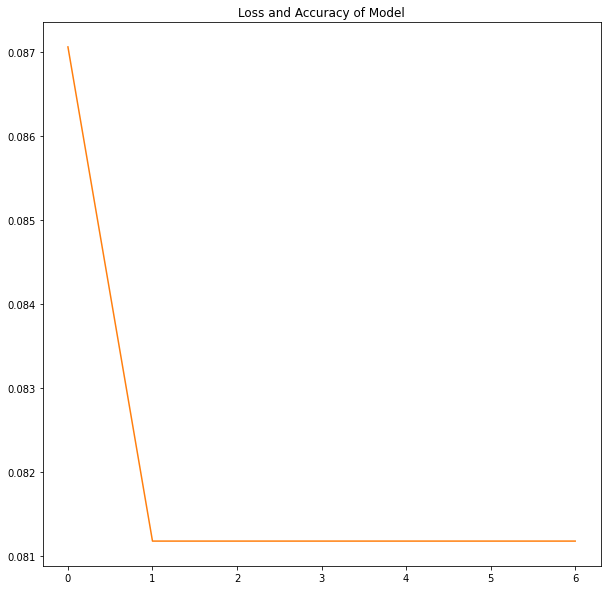

In [28]:
#Ploting a histogram over the epochs
history=pd.DataFrame(hist.history)
plt.figure(figsize=(10,10))
plt.plot(history['loss']);
plt.plot(history['accuracy']);
plt.title('Loss and Accuracy of Model');
plt.savefig('Loss and Accuracy of Model Histogram.png');
plt.show();